<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/generate_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inizializzation.

This Cell download and intstall ROOT in python 2 environment. 

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
!pip install root-numpy
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTreePlayer.so')

Load the funcions (libraries) to retrive data from swift CYGNO server

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
!pip install -q  python-swiftclient
!pip install -q  keystoneauth1
!pip install -q  h5py
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
cy.set_atlas_style('square')
!mkdir -p data

Generate data stream file looking for close cluster: 

1.   download pedestal file [run_ped]
2.   download dafa file/s [runI] from specifc location [dataSelection]
3.   Serch for cluster with DBSCAN


In [0]:
runI          = [1856] 
run_ped       = 1748 
cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
rescale       = 512
nsigma        = 1.5

try:
  fh5 = ("run%d_mean.h5" % (run_ped))
  cmd = 'wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
  fh5 = ("run%d_sigma.h5" % (run_ped))
  cmd = 'wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
except:
  print ("No Pedestal file for run %s on remote repo" % run_ped)

#########################

try:
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

    
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))

    
    
for nRi in range(0,len(runI)):
    try:
        print ('Download and open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
        tmp_file = cy.swift_download_file(cy.swift_root_file(dataSelection, runI[nRi]))
        print ('Open file: '+tmp_file)
        f  = ROOT.TFile.Open(tmp_file);
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        pic, wfm = cy.root_TH2_name(f)
        max_image = len(pic)
        max_wfm = len(wfm)
        print ("# of Images (TH2) Files: %d " % (max_image))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        nImag=max_image
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break

    data_to_save = []
    files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.txt" % 
                     (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))
    for iTr in range(0, max_image):
        if iTr % 10 == 0: # pach in order overcome the problem of ROOT memory garbage
            print ('RUN: ', runI[nRi], 'Event: ', iTr)
            print (iTr, ' >> Close and re-Open: ', tmp_file)
            f.Close()
            f  = ROOT.TFile.Open(tmp_file);

        image = rtnp.hist2array(f.Get(pic[iTr])).T

        rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
        rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

        edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
        points          = np.array(np.nonzero(edges)).T.astype(float) 
        scaler          = StandardScaler()
        X_scaled        = scaler.fit_transform(points)

        dbscan          = DBSCAN(eps=0.05, min_samples = 2)
        dbscan.fit(points)

        clusters = dbscan.fit_predict(X_scaled)

        for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
            ph = 0.
            # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
            yc = points[:,1][dbscan.labels_==ic]
            xc = points[:,0][dbscan.labels_==ic]
            ph, dim = cy.cluster_par(yc, xc, rebin_image)
            width, height, pearson = cy.confidence_ellipse_par(yc,xc)
            for j in range(0, dim):
                x=int(xc[j])
                y=int(yc[j])
                #ph += rebin_image[y,x]
                if j == 0:
                    x0start = x
                    y0start = y
            x0end = x
            y0end = y
            data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                                 x0start, y0start, x0end, y0end, width, height, pearson])

    np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
    print ("out file", files)
    if not cy.rm_file(tmp_file):
        print (">> File "+tmp_file+" removed")

more... this cell generate localy pedestal and sigma images


In [0]:
dataSelection = 'LAB'
run_ped       = 1748
start_image_to_read = 0
max_image_to_read = 0

try:
    print ('Download and open file: '+cy.swift_root_file(dataSelection, run_ped))
    tmp_file = cy.swift_download_file(cy.swift_root_file(dataSelection, run_ped))
    print ('Open file: '+tmp_file)
    f  = ROOT.TFile.Open(tmp_file);
    print ('Find Keys: '+str(len(f.GetListOfKeys())))
    pic, wfm = cy.root_TH2_name(f)
    max_image = len(pic)
    max_wfm = len(wfm)
    print ("# of Images (TH2) Files: %d " % (max_image))
    print ("# of Waveform (TH2) Files: %d " % (max_wfm))
    nImag=max_image
    if max_image_to_read != 0:
        nImag = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (start_image_to_read, nImag))

    m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
    s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

    n0 = 0
    for iTr in range(start_image_to_read, nImag):

        if iTr % 50 == 0:
            print (iTr, ' >> Close and re-Open: ', tmp_file)
            f.Close()
            f  = ROOT.TFile.Open(tmp_file);

        image = rtnp.hist2array(f.Get(pic[iTr])).T
        m_image += image
        s_image += image**2 
        if n0 > 0:  # print progress and debung info for poit 200, 200...
            print ("Image[200,200]: %d => %.2f %.2f %.2f " % (iTr,
                                              image[200,200],
                                              np.sqrt((s_image[200,200] - 
                                                      m_image[200,200]**2 
                                                      / (n0+1)) / n0),
                                              m_image[200,200]/(n0+1),
                                              ))
        n0 += 1
    m_image = m_image/n0
    s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))

    ###### print Info and Save OutPut ######################################

    print ("sigma %f" % (s_image[200,200]))
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    cy.write_image_h5(fileoutm, m_image)
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    cy.write_image_h5(fileouts, s_image)
    print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))
    if not cy.rm_file(tmp_file):
        print (">> File "+tmp_file+" removed")

except:
    print ("ERROR: No file %d" % (run_ped))
    


more... this cell download existing pedestal files

In [0]:
run_ped       = 1748
fh5 = ("run%d_mean.h5" % (run_ped))
cmd = 'wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
os.system(cmd)
fh5 = ("run%d_sigma.h5" % (run_ped))
cmd = 'wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
os.system(cmd)
!ls data


In [51]:
!ls -lsrt data

total 66108
32772 -rw-r--r-- 1 root root 33556480 Mar 13 10:22 run1748_mean.h5
32772 -rw-r--r-- 1 root root 33556480 Mar 13 10:22 run1748_sigma.h5
  564 -rw-r--r-- 1 root root   573468 Mar 13 10:23 dbscan_run1856_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100_ped_1748.txt


load data stream file

In [0]:
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]

C_file = './data/dbscan_run1856_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100_ped_1748.txt' 

df = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.


var = C_file.split('/')[-1].split('_')
var_name = []
var_val = []
for i in range(0, len(var)-1, 2):
    var_name.append(var[i:i+1][0])
    var_val.append(var[i+1:i+2][0])


load LEMON 

In [79]:

# LEMON
x_resolution = 2048
phKev        = 2045.15/5.9
pixelscale   = 0.125 
    
rescale = float(var_val[var_name.index("rescale")])


xyscale = x_resolution/rescale
rescale_pixelscale = xyscale*pixelscale
print("Scale: %d Pixel/Mpixel, %.2f [mm/Mpixel]" % (xyscale, rescale_pixelscale))

Scale: 4 Pixel/Mpixel, 0.50 [mm/Mpixel]


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


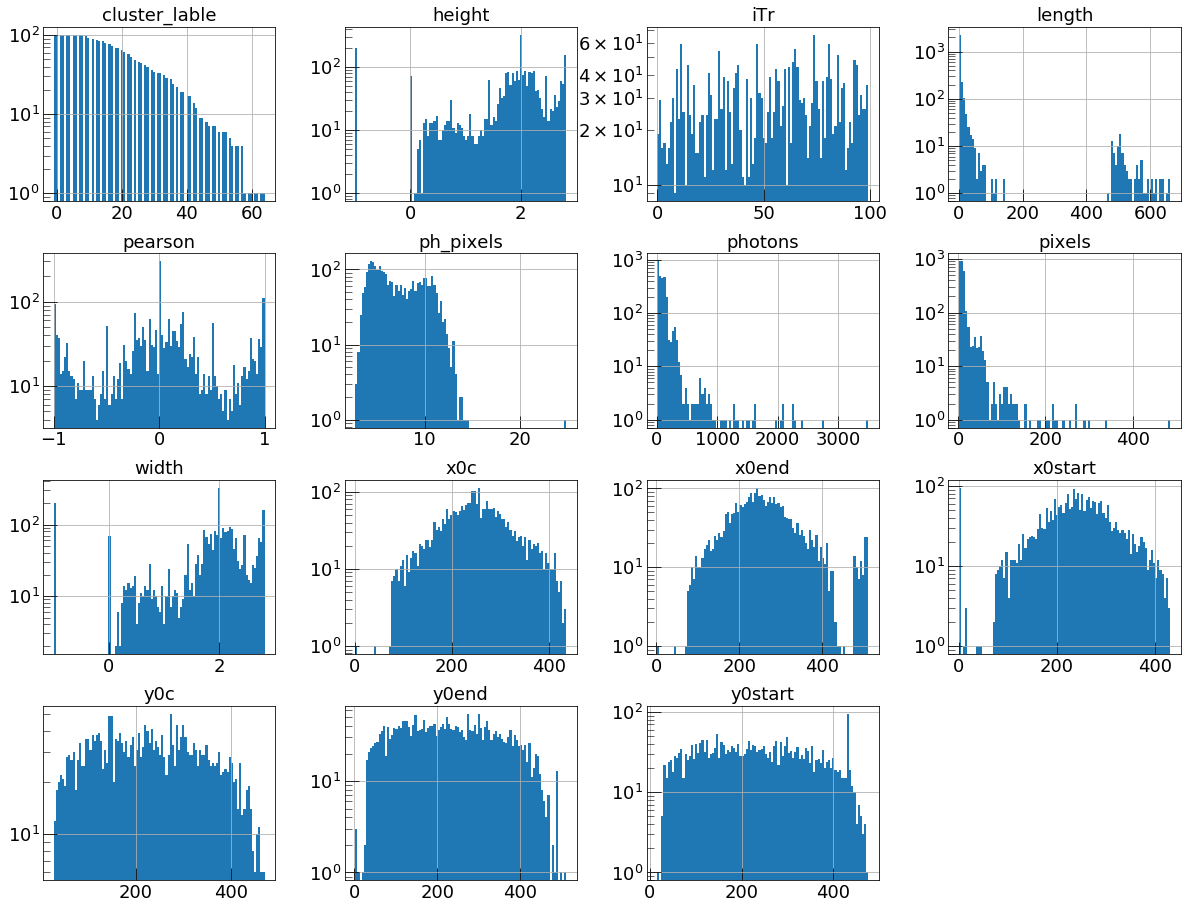

In [54]:
df.head()
df.hist(bins=100, figsize=(20, 6), log=True)
plt.show()

Fidical Ellips: 100.00, 120.00 [mm]


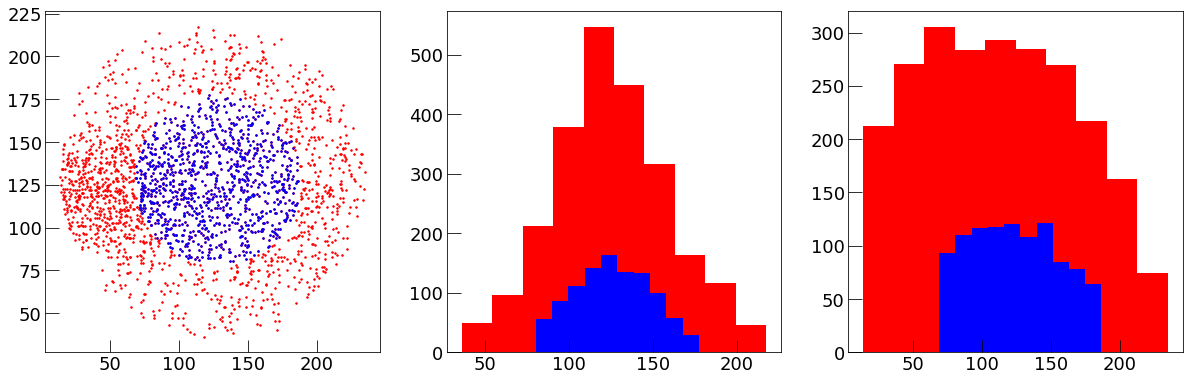

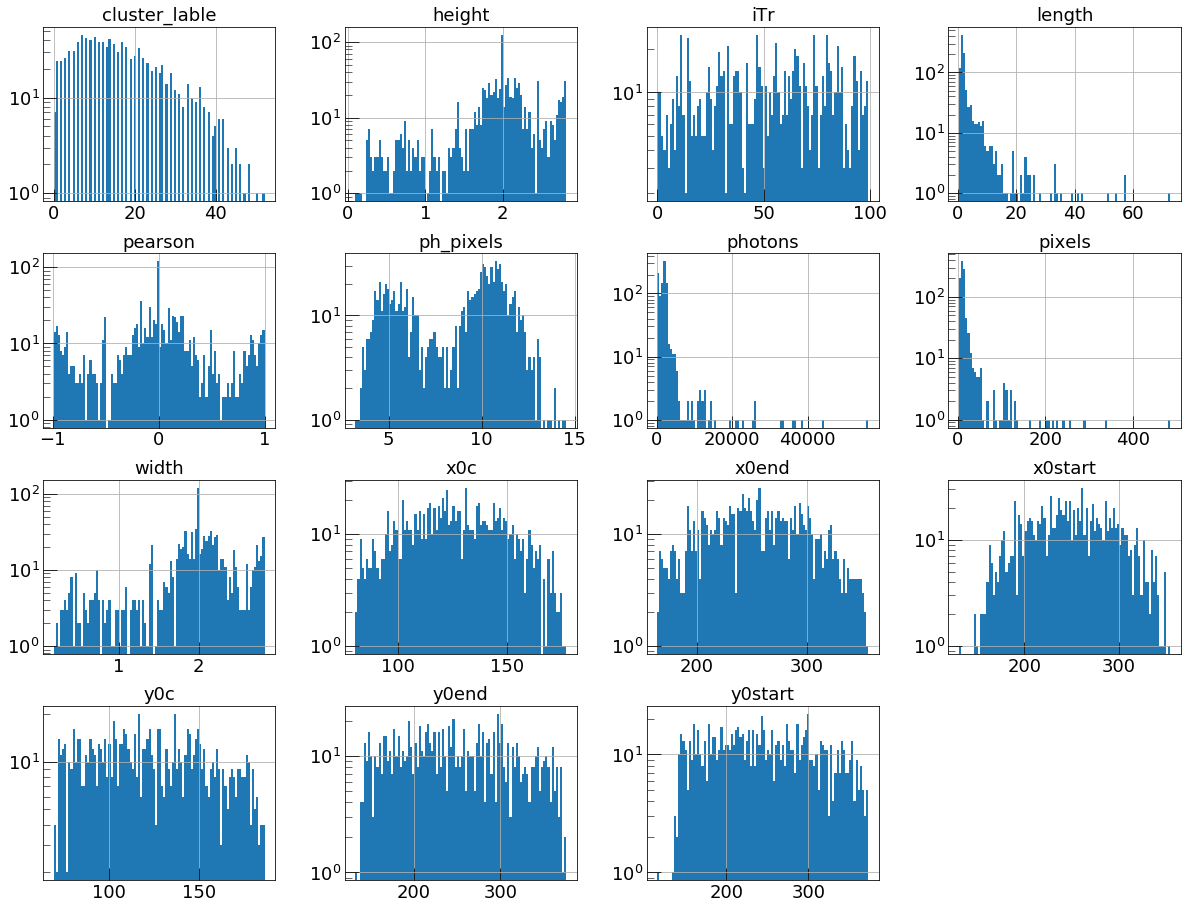

In [74]:
dfc = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

# Normalization
dfc.loc[:,'photons']  =dfc['photons']*xyscale*xyscale
dfc.loc[:,'length']   =dfc['length']*rescale_pixelscale
dfc.loc[:,'x0c']      =dfc['x0c']*rescale_pixelscale
dfc.loc[:,'y0c']      =dfc['y0c']*rescale_pixelscale

# fiducializzation


DX = 0 
DY = 0
a = 100. # mm 
b = 120. # mm

a0 = a*0.5
b0 = b*0.5
#################################################


print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

d0 = x_resolution*pixelscale/2

fig, ax = plt.subplots(1,3, figsize=(20, 6))

y = dfc['y0c']
x = dfc['x0c']
x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
ax[0].plot(y, x, 'r.', markersize=3)
ax[0].plot(y1, x1, 'b.', markersize=3)

ax[1].hist(x, color='r')
ax[1].hist(x1, color='b')
ax[2].hist(y, color='r')
ax[2].hist(y1, color='b')
plt.show()

dfc = dfc[((dfc['x0c']-d0)**2/a0**2 + (dfc['y0c']-d0)**2/b0**2 )< 1]

dfc.hist(bins=100, figsize=(20,15), log=True)
plt.show()

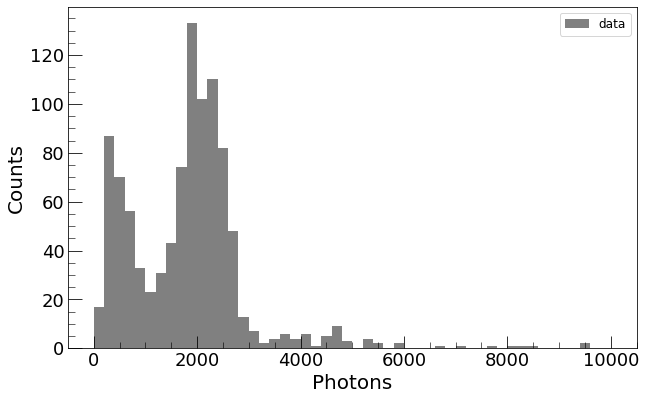

In [75]:
Fe = True
cy.set_atlas_style('medium')
bins=50
plt.hist(dfc['photons'], bins=bins, range=(0,10000), label='data', color='gray')
plt.xlabel("Photons")
plt.ylabel("Counts")


plt.legend(loc=1, prop={'size':'large'})
plt.minorticks_on()
plt.show()